In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline


In [45]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(12)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


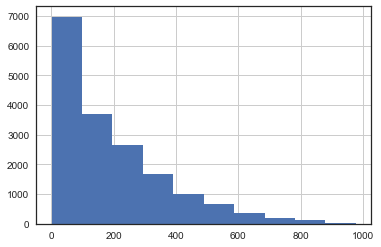

In [46]:
bike_rentals['cnt'].hist()
plt.show()

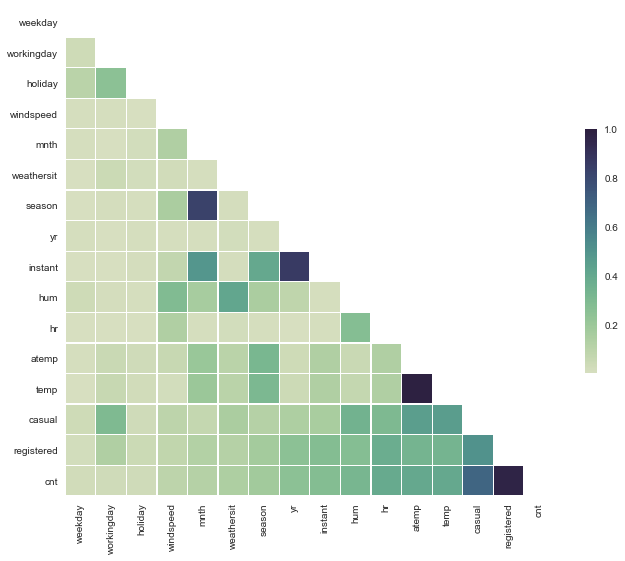

In [47]:
#Compute the pairwise correlation coefficients between all of the columns in train_subset.
results = bike_rentals.corr()
sorted_corrs = abs(results['cnt']).sort_values()

# get the correlation of the columns with each other from the orginal dataset
corrmat = abs(bike_rentals[sorted_corrs.index].corr())
    
sns.set(style="white")
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
sns.heatmap(corrmat, mask=mask, cmap=cmap, square=True, linewidths=.25, cbar_kws={"shrink": .5})
            

In [48]:
sorted_corrs

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [49]:
def assign_label(hour):
    
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [50]:
bike_rentals[['hr','time_label']].head(20)

,hr,time_label
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4
5,5,4
6,6,1
7,7,1
8,8,1
9,9,1



<b>Error metric</b>
The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [52]:
# select 80% of the data for the training set
train = bike_rentals.sample(frac=0.8)

# This line will select any rows in bike_rentals that aren't found in train to be in the testing set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

<b>Linear regression</b> will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

In [57]:
features = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']
target = 'cnt'

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [60]:
lr = LinearRegression()
lr.fit(train[features], train[target])
predictions = lr.predict(test[features])
mse = mean_squared_error(test[target],predictions)
mse

16343.405117495378

<b>Error</b>
The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. 
Larger errors are penalized more with MSE, which leads to a higher total error.

In [63]:
from sklearn.tree import DecisionTreeRegressor 

dtr = DecisionTreeRegressor(min_samples_leaf=5)
dtr.fit(train[features], train[target])
predictions = dtr.predict(test[features])
mse = mean_squared_error(test[target],predictions)
mse

2387.0741672985869

In [64]:
dtr = DecisionTreeRegressor(min_samples_leaf=2)
dtr.fit(train[features], train[target])
predictions = dtr.predict(test[features])
mse = mean_squared_error(test[target],predictions)
mse

2622.7505993479094

<b>Decision tree error</b>
By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

In [67]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(min_samples_leaf=5)
rfr.fit(train[features], train[target])
predictions = rfr.predict(test[features])
mse = mean_squared_error(test[target],predictions)
mse

1769.3013889361732

In [68]:
rfr = RandomForestRegressor(min_samples_leaf=2)
rfr.fit(train[features], train[target])
predictions = rfr.predict(test[features])
mse = mean_squared_error(test[target],predictions)
mse

1678.9732766380498

<b>Random forest error</b>
By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.